# Train a BNN to classify MNIST using neural SVGD

In [1]:
# for leonhard
import os
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
os.environ['XLA_FLAGS']

'--xla_gpu_cuda_data_dir=/cluster/apps/gcc-6.3.0/cuda-10.1.243-n6qg6z5js3zfnhp2cfg5yjccej636czm'

In [18]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/learning_particle_gradients/")
sys.path.append("../../experiments/")

import argparse
import matplotlib.pyplot as plt
from jax import vmap, random
import jax.numpy as jnp
import numpy as onp
from tqdm import tqdm
import optax
import bnn
import models
import metrics
import mnist
import config as cfg
import utils
from jax import jit, grad, value_and_grad

# Config
key = random.PRNGKey(0)
MAX_TRAIN_STEPS = 100  # df 100
META_LEARNING_RATE = 1e-3  # df 1e-3; should be as high as possible; regularize w/ max steps
PATIENCE = 5  # df 5; early stopping not v helpful, bc we overfit on all ps

NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 10**2
STEP_SIZE = 4e-5
PATIENCE = 15
MAX_TRAIN_STEPS = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# init particles and dynamics model

In [57]:
def init_particles_fn(subkey):
    init_particles = vmap(bnn.init_flat_params)(random.split(subkey, NUM_SAMPLES))
    return init_particles


key, subkey = random.split(key)
init_particles = init_particles_fn(subkey)
opt = optax.sgd(STEP_SIZE)

# opt = optax.chain(
#     optax.scale_by_adam(),
#     optax.scale(-STEP_SIZE),
# )

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[512, 512, 512, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=False,
                               normalize_inputs=True)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

minibatch_vdlogp = jit(vmap(grad(bnn.minibatch_logp), (0, None)))

In [20]:
init_particles.shape

(100, 4594)

In [41]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(mnist.training_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels)
    return loglikelihood(x) + bnn.log_prior(bnn.unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = bnn.unravel(x)
        logits = bnn.model.apply(params, images)
        return -mnist.train_data_size/cfg.batch_size * bnn.crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 2958937.8
hutchinson estimate: 2959470.0
ratio: 0.9998202


In [68]:
v = neural_grad.get_field(subkey, xs, neural_grad.params)

In [69]:
stein.stein_discrepancy_hutchinson(subkey, xs, logp, v)

DeviceArray(-183984.06, dtype=float32)

# train to match true f directly, via squared error

In [58]:
@jit
def squared_error_loss(f_params, particles):
    v = neural_grad.get_field(subkey, particles, f_params)
    return jnp.mean((v(particles) + vmap(f)(particles))**2)

In [59]:
adam = optax.adam(1e-4)
adam_state = adam.init(neural_grad.params)

In [60]:
@jit
def sel_step(subkey, params, adam_state):
    xs = init_particles_fn(subkey)
    loss, grads = value_and_grad(squared_error_loss)(params, xs)
    grads, adam_state = adam.update(grads, adam_state, params)
    params = optax.apply_updates(params, grads)
    return params, adam_state, {"loss": loss.mean()}

In [61]:
bnn.ravel(neural_grad.params)

DeviceArray([ 0.        ,  0.        ,  0.        , ...,  0.03660478,
             -0.04404281,  1.        ], dtype=float32)

In [65]:
rdata = {}
for _ in tqdm(range(100)):
    key, subkey = random.split(key)
    neural_grad.params, adam_state, aux = sel_step(subkey, neural_grad.params, adam_state)
    metrics.append_to_log(rdata, aux)

100%|██████████| 100/100 [00:01<00:00, 56.56it/s]


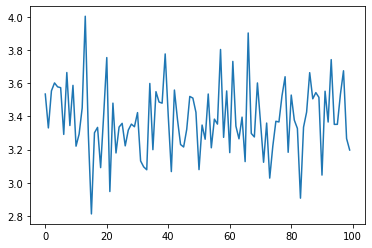

In [66]:
plt.plot(rdata['loss'])

# don't sample new

In [6]:
key, subkey = random.split(key)
split_particles = particles.next_batch(subkey)
split_dlogp = [minibatch_vdlogp(x, first_batch)
               for x in split_particles]

In [467]:
# neural_grad.init_params()
neural_grad.train(
    split_particles=split_particles,
    split_dlogp=split_dlogp,
    n_steps=MAX_TRAIN_STEPS,
)
# particles.step(neural_grad.get_params())

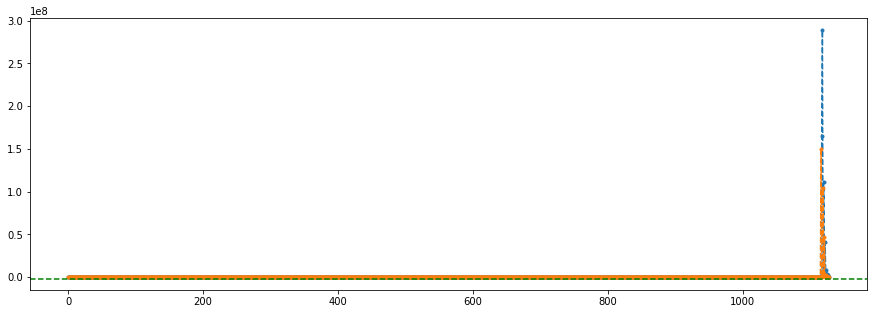

In [430]:
# generate markings based on num_steps
a = 0
b = -1
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])

plt.plot(neural_grad.rundata['training_loss'][a:b], "--.")
plt.plot(neural_grad.rundata['validation_loss'][a:b], "--.")
# plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

## sample new particles each step (ideal)

In [23]:
for _ in tqdm(range(100)):
    key, subkey = random.split(key)
    particles.particles = init_particles_fn(subkey)

    key, subkey = random.split(key)
    new_split_particles = particles.next_batch(subkey)
    new_split_dlogp = [minibatch_vdlogp(x, first_batch)
                       for x in new_split_particles]

    neural_grad.train(
        split_particles=new_split_particles,
        split_dlogp=new_split_dlogp,
        n_steps=1,
    )
# particles.step(neural_grad.get_params())

100%|██████████| 100/100 [00:07<00:00, 13.19it/s]


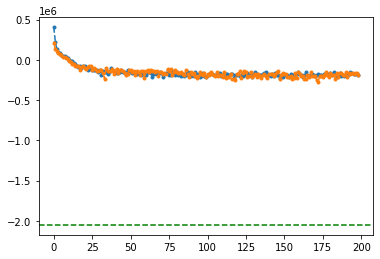

In [24]:
a = 0
b = -1


plt.plot(neural_grad.rundata['training_loss'][a:b], "--.")
plt.plot(neural_grad.rundata['validation_loss'][a:b], "--.")
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

# sample training, fix val

100%|██████████| 1000/1000 [00:39<00:00, 25.45it/s]


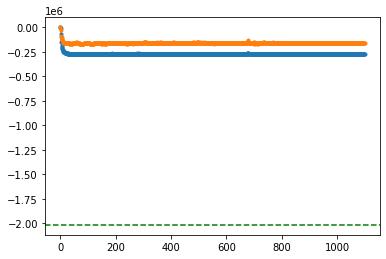

In [427]:
for _ in tqdm(range(1000)):
    key, subkey = random.split(key)
    # neural_grad.params = neural_grad.init_params(subkey)
    particles.particles = particles.init_particles(subkey)

    key, subkey = random.split(key)
    new_split_particles = particles.next_batch(subkey)
    new_split_dlogp = [minibatch_vdlogp(x, first_batch)
                       for x in split_particles]

    # neural_grad.init_params()
    neural_grad.train(
        split_particles=(new_split_particles[0], split_particles[1]),
        split_dlogp=(new_split_dlogp[0], split_dlogp[1]),
        n_steps=1,
    )
# particles.step(neural_grad.get_params())

a = 0
b = -1


plt.plot(neural_grad.rundata['training_loss'][a:b], "--.")
plt.plot(neural_grad.rundata['validation_loss'][a:b], "--.")
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

# train

In [469]:
# N_PARTICLE_STEPS = 5
key, fixed_key = random.split(key)
def step(split_particles, split_dlogp):
    """one iteration of the particle trajectory simulation"""
    neural_grad.params = neural_grad.init_params()
    neural_grad.train(
        split_particles=split_particles,
        split_dlogp=split_dlogp,
        n_steps=MAX_TRAIN_STEPS,
    )
    particles.step(neural_grad.get_params())


@jit
def compute_eval(step_counter, ps):
    stepdata = {
        "accuracy": (step_counter, bnn.compute_acc_from_flat(ps)),
        "particle_mean": (step_counter, ps.mean()),
    }
    return stepdata

sgld = utils.sgld(5e-9)
sgld_state = sgld.init(init_particles)


@jit
def sgld_step(particles, dlogp, sgld_state):
    """Update param_set elements in parallel using Langevin dynamics."""
    g, sgld_state = sgld.update(-dlogp, sgld_state, particles)
    particles = optax.apply_updates(particles, g)
    aux = {
        "global_grad_norm": optax.global_norm(g),
    }
    return particles, sgld_state, aux

In [470]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 200
sgld_aux = {}
for step_counter in tqdm(range(num_steps)):
    key, subkey = random.split(key)
    train_batch = next(mnist.training_batches)
    split_particles = particles.next_batch(key)
    split_dlogp = [minibatch_vdlogp(x, train_batch)
                   for x in split_particles]
    
    step(split_particles, split_dlogp)

    # SGLD step
#     particles.particles, sgld_state, aux = sgld_step(
#         particles.particles, jnp.append(*split_dlogp, axis=0), sgld_state)
#     metrics.append_to_log(sgld_aux, aux)

    if step_counter % 10 == 0:
        metrics.append_to_log(particles.rundata,
                              compute_eval(step_counter, particles.particles))
# neural_grad.done()
# particles.done()

100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


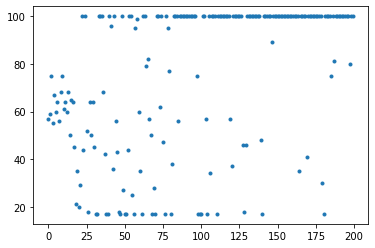

In [471]:
plt.plot(neural_grad.rundata['train_steps'], ".")

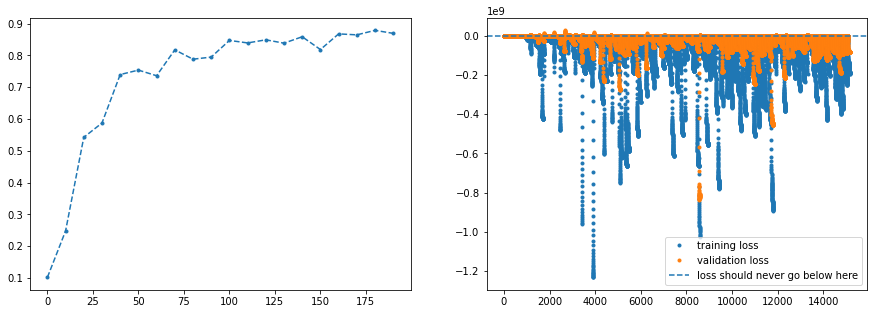

In [472]:
fig, axs = plt.subplots(1, 2, figsize=[15, 5])

ax = axs[0]
ax.plot(*zip(*particles.rundata['accuracy']), "--.")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'], ".", label="training loss")
ax.plot(neural_grad.rundata['validation_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--")
ax.legend()

In [480]:
particles.rundata['accuracy'][-1]

(Buffer(190, dtype=int32), Buffer(0.86920583, dtype=float32))

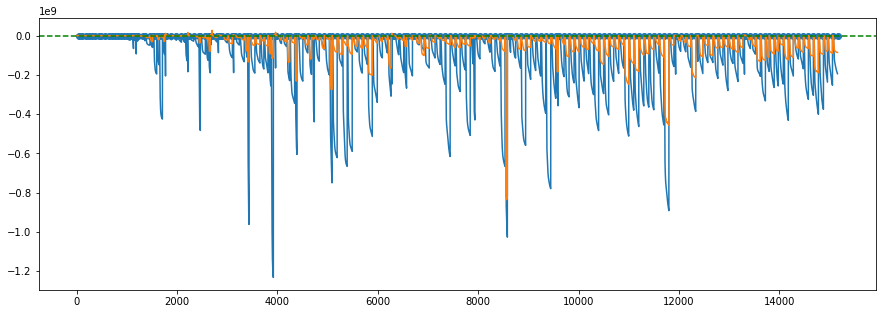

In [473]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])

plt.plot(neural_grad.rundata['training_loss'])
plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

step 53 to step 71.


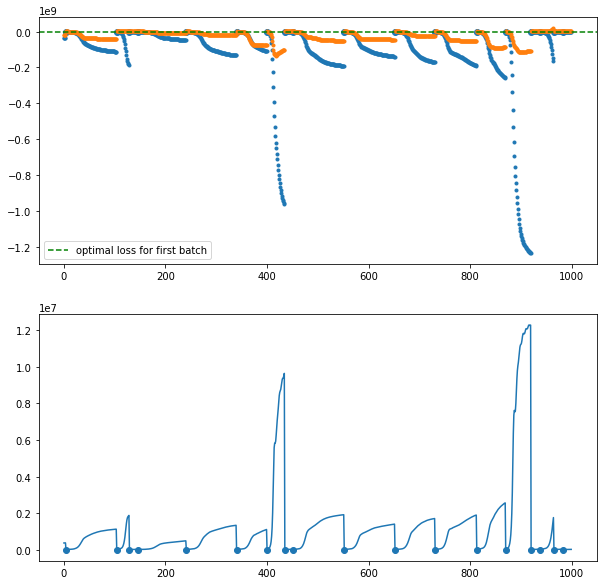

In [478]:
a = 3000
b = 4000
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'][a:b], ".")
ax.plot(neural_grad.rundata['validation_loss'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=min_loss, label="optimal loss for first batch", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2_norm'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

In [21]:
particles.rundata['accuracy'][-1]

(Buffer(190, dtype=int32), Buffer(0.8127612, dtype=float32))

In [33]:
with open('nvgd.csv', "w") as f:
    f.write('step,accuracy')

In [34]:
with open('nvgd.csv', "a") as f:
    for i, a in enumerate(particles.rundata['accuracy']):
        f.write(f'{i*10},{a}\n')

In [33]:
onp.mean(particles.rundata["accuracy"][-10:])

0.85944146

In [ ]:
plt.plot(neural_grad.rundata["global_gradient_norm"])

In [77]:
# trajectories = onp.array(particles.rundata['particles'])
# trajectories.shape

In [76]:
# # visualize trajectory avg across dimensions (distinguish particles)
# fig, axs = plt.subplots(2, 1, figsize=[10, 8])

# ax = axs[0]
# ax.plot(trajectories.mean(axis=2));  # avg across dims

# ax = axs[1]
# ax.plot(trajectories[:, :, 1]);  # watch single param (aka single dimension)

In [ ]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories[:, 11, :]); # watch single particle

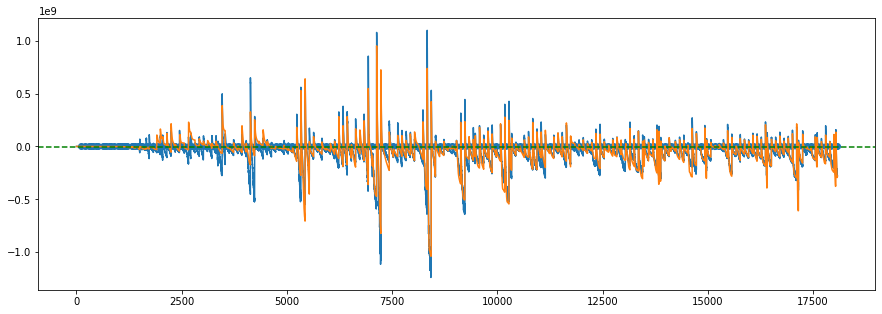

In [36]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])

plt.plot(neural_grad.rundata['training_loss'])
plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

step 0 to step 30.


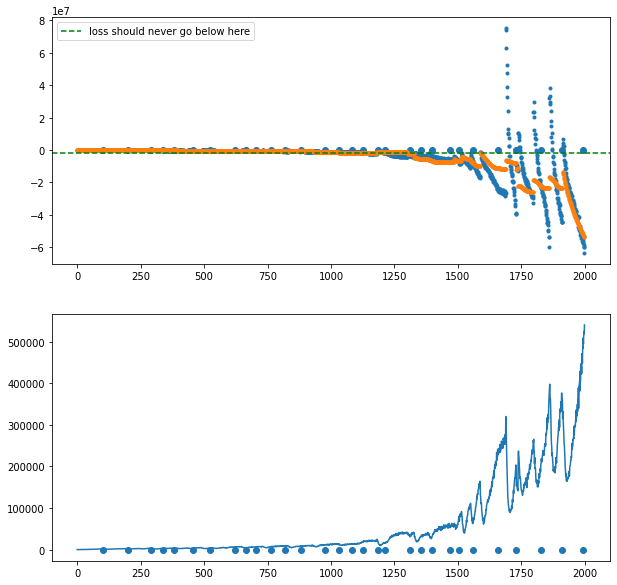

In [59]:
a = 0
b = 2000
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'][a:b], ".")
ax.plot(neural_grad.rundata['validation_loss'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2_norm'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

# particle gradient norms

In [ ]:
gs = neural_grad.grads(particles.particles)
optax.global_norm(gs)

In [ ]:
print("norm pre upate :", particles.rundata['global_grad_norm'][0])
print("norm post upate:", particles.rundata['global_grad_norm_post_update'][0])

In [ ]:
plt.plot(particles.rundata['global_grad_norm'])

In [ ]:
plt.plot(particles.rundata['global_grad_norm_post_update'])

In [ ]:
optax.global_norm(vmap(unravel)(particles.particles))

In [ ]:
jnp.sqrt(jnp.sum(particles.particles**2))

# model gradient norms

### interlude: why accuracy no change?

In [ ]:
all_preds = vmap(lambda ps: model.apply(unravel(ps), val_images[:128]).argmax(axis=1))(particles.rundata['particles'][-1])
onp.unique(all_preds, return_counts=True)

### continue with scheduled programming